In [9]:
# Checks for the operating system that the script is being run on determines the data path that is to be used
import platform
operating_system=platform.system()
if operating_system=='Windows':
    data_directory=("D:\\KSP\\Study\\Houston\\Projects\\TSLOExperiments\\TSLO_core\\External display\\Results\\S01\\PilotData")
elif operating_system=='Linux':
    dataframe_dir=('/tmp/hd/Reading_experiment/Analysis Code & Plots/reading_analysis/expt2/Dataframe')
    data_directory=('/tmp/hd/Reading_experiment/Reading Data/reading/Results/Experiment 2 King Devick Mode/All Subjects/Raw Data')
else:
    dataframe_dir=('/tmp/hd/Reading_experiment/Analysis Code & Plots/reading_analysis/expt2/Dataframe')
    data_directory=('/tmp/hd/Reading_experiment/Reading Data/reading/Results/Experiment 2 King Devick Mode/All Subjects/Raw Data')

In [10]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pylab
from scipy.optimize import curve_fit

# Change this to the directory that contains the dataframes from the experiment
os.chdir(data_directory)
filelist=os.listdir()
EyePos=[]
markerData=[]
responseData=[]
SaccData=[]
for filename in filelist:
    if 'EyePos' in filename:
        data=pd.read_csv(filename,names=['Time','Xpos','Ypos'],index_col=False)
        data['Filename']=filename
        EyePos.append(data)
    elif 'markerInfo' in filename:
        data=pd.read_csv(filename,names=['TimeStamp','FrameNo','LineNo'],index_col=False)
        data['Filename']=filename
        markerData.append(data)
    elif 'Crowding' in filename:
        data=pd.read_csv(filename,header=0,index_col=False)
        data['Filename']=filename       
        responseData.append(data)
    elif 'SaccStats' in filename:
        data=pd.read_csv(filename,names=['SaccDirection','SaccAmps','SaccVel','SaccStartIdx','SaccEndIdx','SaccStartTime','SaccEndTime'],index_col=False)
        data['Filename']=filename
        SaccData.append(data)
    
EyePos=pd.concat(EyePos)
markerData=pd.concat(markerData)
responseData=pd.concat(responseData)
SaccData=pd.concat(SaccData)
#This needs to be done for now (wrongly scaled the time scale)
EyePos['Time']=EyePos['Time']*512/3
EyePos['Xpos']=EyePos['Xpos']*60
EyePos['Ypos']=EyePos['Ypos']*60

# psychometric function
def sigmoid(x, x0, k):
    chance = 0.25  # between 0 and 1
    y = chance + (1-chance) / (1 + np.exp(-k*(x-x0)))
    return y

#calculating BCEA (68% confidence ellispe)
def CalcBCEA(xdata,ydata):
    rho=np.corrcoef( xdata, ydata)[0,1]
    bcea=2 * 2.291/2.0 * np.pi * np.std(xdata) * np.std(ydata) * np.sqrt(1-rho**2)
    return bcea
#     print( '%0.2f'%bcea )


Populating the interactive namespace from numpy and matplotlib


C:\Users\krish\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


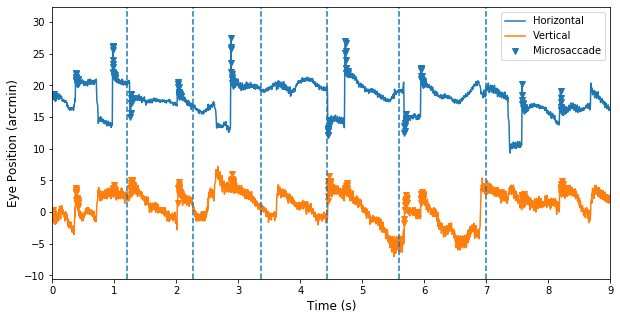

In [32]:
plt.figure(figsize=(10,5))
EyePosFilename='S01_S1_T003_EyePos.csv'
saccFilename='S01_S1_T003_SaccStats.csv'
markerDataFilename='S01_S1_T003_markerInfo.csv'
EyePosFiltered=EyePos.query("Filename==@EyePosFilename")
markerDataFiltered=markerData.query("Filename==@markerDataFilename")
SaccFiltered=SaccData.query("Filename==@saccFilename")
plt.plot(EyePosFiltered['Time'],EyePosFiltered['Xpos'],label='Horizontal')
plt.plot(EyePosFiltered['Time'],EyePosFiltered['Ypos'],label='Vertical')
if len(SaccFiltered)>0:
    for i in range(len(SaccFiltered)):
        x=EyePosFiltered['Time'].iloc[int(SaccFiltered['SaccStartIdx'].iloc[i]):int(SaccFiltered['SaccEndIdx'].iloc[i])]
        y1=EyePosFiltered['Xpos'].iloc[int(SaccFiltered['SaccStartIdx'].iloc[i]):int(SaccFiltered['SaccEndIdx'].iloc[i])]
        y2=EyePosFiltered['Ypos'].iloc[int(SaccFiltered['SaccStartIdx'].iloc[i]):int(SaccFiltered['SaccEndIdx'].iloc[i])]
        plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
        plt.plot(x,y2,'v',color='C1')
yrange=plt.gca().get_ylim()
for i in range(len(markerDataFiltered)):
    ax=plt.axvline(x=markerDataFiltered['TimeStamp'][i],ymin=0,ymax=1,ls='--')
plt.xlim(0,9)
plt.xlabel('Time (s)', size=12)
plt.ylabel('Eye Position (arcmin)', size=12)
plt.legend(loc='best')
# plt.savefig('SampleEyeTraceWithEventMarkers.pdf')

Text(0, 0.5, 'Proportion correct')

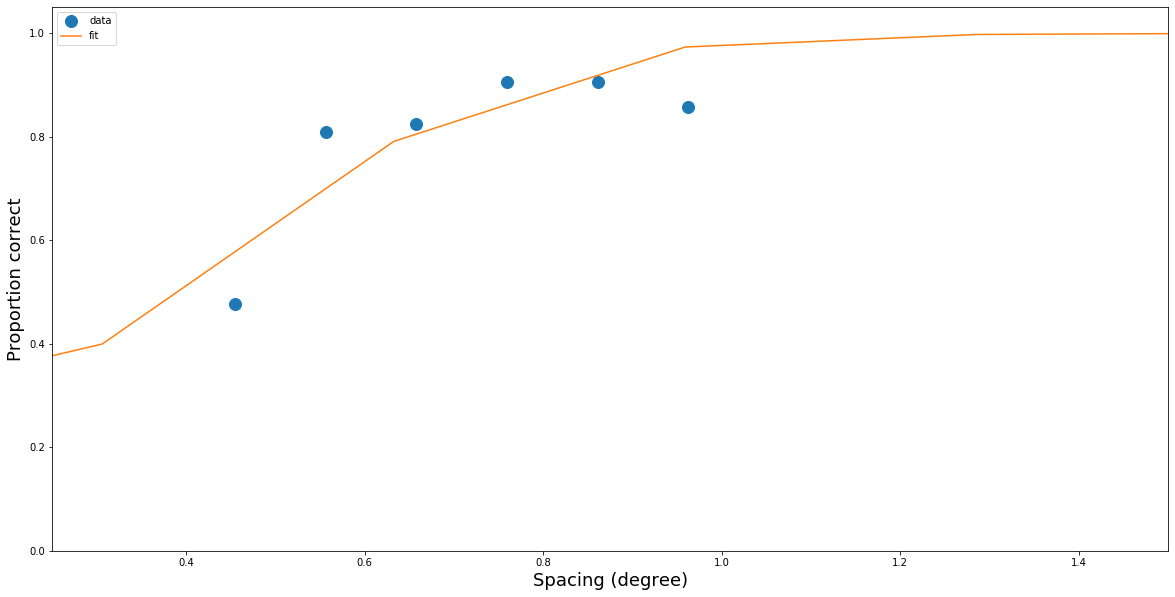

In [28]:
plt.figure(figsize=(20,10))
responseCombined=responseData.groupby(['spacing']).mean()['corr'].reset_index()
 #one data poiint seems to be weird, modified to account for that 
responseCombined=responseCombined.query("corr!=1")
xdata=responseCombined['spacing']
ydata=responseCombined['corr']

# fitting
popt, pcov = curve_fit(sigmoid, xdata, ydata)
x = np.linspace(-1, 15, 50)
y = sigmoid(x, *popt)
pylab.plot(xdata,ydata,'o',label='data',markersize=12)
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
plt.xlim(0.25,1.5)
plt.xlabel('Spacing (degree)', size=18)
plt.ylabel('Proportion correct', size=18)
# plt.savefig('PsychometricFunctionAllTrials.pdf')

In [111]:
stepSize=0.05
numSteps=8
maxTime=stepSize*(numSteps)
# timeBins=np.linspace(0,maxTime,5)
timeBins=[-0.200,-0.150,-0.100,-0.05,0,0.05,0.100,0.150,0.200]
bceaData=pd.DataFrame({'Subject_ID':[],'timebin':[],'BCEA':[],'markerIdx':[]})
for filename in filelist:
    if 'EyePos' in filename:
        EyePosFiltered=EyePos.query("Filename==@filename")
        for markerIdx in range(len(markerDataFiltered)): 
            preStimulus=EyePosFiltered[EyePosFiltered['Time']<markerDataFiltered['TimeStamp'][markerIdx]]
            postStimulus=EyePosFiltered[EyePosFiltered['Time']>markerDataFiltered['TimeStamp'][markerIdx]]
            for binIdx in range(numSteps):
                if binIdx<4:
                    binMin=preStimulus['Time'].max()-abs(timeBins[binIdx])
                    binMax=preStimulus['Time'].max()-abs(timeBins[binIdx+1])
                    binData=preStimulus.query("(Time>@binMin)& (Time<@binMax) ")
                    xdata=binData['Xpos']
                    ydata=binData['Ypos']
                    bcea=CalcBCEA(xdata,ydata)
                    bceaData=bceaData.append({'Filename':filename,'timebin':'%g - %g'%(timeBins[binIdx]*1000,timeBins[binIdx+1]*1000),'BCEA':bcea,'markerIdx':markerIdx},ignore_index=True)
                else:
                    binMin=postStimulus['Time'].min()+abs(timeBins[binIdx])
                    binMax=postStimulus['Time'].min()+abs(timeBins[binIdx+1])
                    binData=postStimulus.query("(Time>@binMin)& (Time<@binMax) ")
                    xdata=binData['Xpos']
                    ydata=binData['Ypos']
                    bcea=CalcBCEA(xdata,ydata)
                    bceaData=bceaData.append({'Filename':filename,'timebin':'%g - %g'%(timeBins[binIdx]*1000,timeBins[binIdx+1]*1000),'BCEA':bcea,'markerIdx':markerIdx},ignore_index=True)

C:\Users\krish\Anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\krish\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\krish\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\krish\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\krish\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Text(0, 0.5, 'BCEA (arcmin^2)')

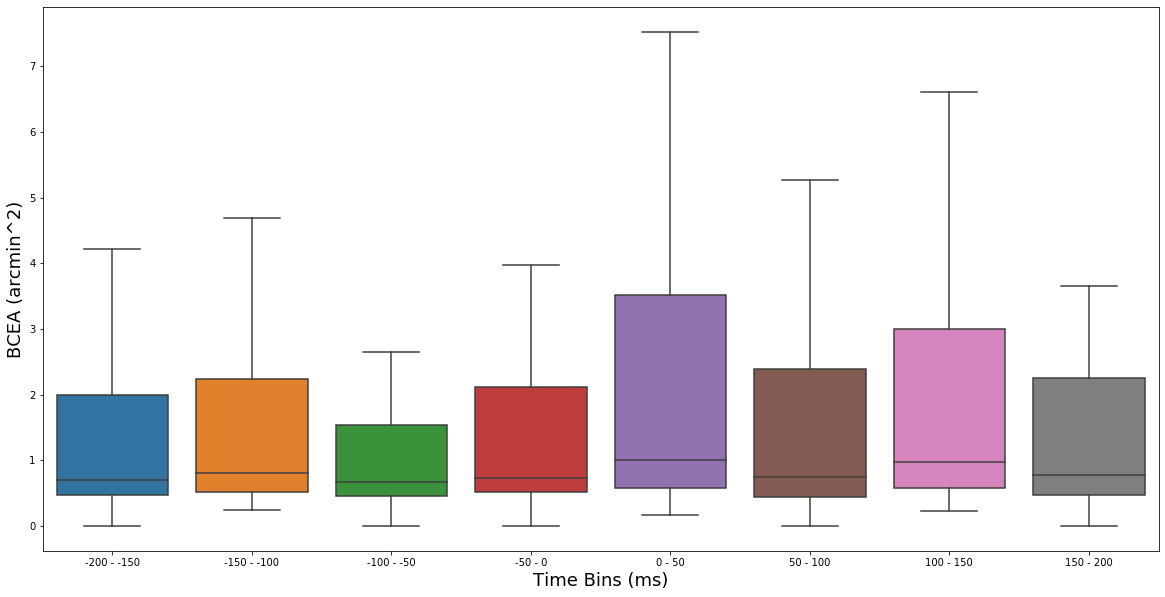

In [112]:
plt.figure(figsize=(20,10))
#outliers are hidden for the time being as it makes it harder to visualize the data
sns.boxplot(x="timebin",y="BCEA",data=bceaData,showfliers = False)
plt.xlabel('Time Bins (ms)', size=18)
plt.ylabel('BCEA (arcmin^2)', size=18)
# plt.semilogy()
# plt.savefig('BCEAVsTimebins.pdf')

In [76]:
stepSize=0.05
numSteps=8
maxTime=stepSize*(numSteps)
# timeBins=np.linspace(0,maxTime,5)
timeBins=[-0.200,-0.150,-0.100,-0.05,0,0.05,0.100,0.150,0.200]
MicrosaccadeData=pd.DataFrame({'SubjectID':[],'timebin':[],'NumMicrosaccades':[],'markerIdx':[]})
for filename in filelist:
    if 'SaccStats' in filename:
        print(filename)
        SaccDataFiltered=SaccData.query("Filename==@filename")
        for markerIdx in range(len(markerDataFiltered)): 
            preStimulus=SaccDataFiltered[SaccDataFiltered['SaccStartTime']<markerDataFiltered['TimeStamp'][markerIdx]]
            postStimulus=SaccDataFiltered[SaccDataFiltered['SaccStartTime']>markerDataFiltered['TimeStamp'][markerIdx]]
            for binIdx in range(numSteps):
                if binIdx<4:
                    binMin=preStimulus['SaccStartTime'].max()-abs(timeBins[binIdx])
                    binMax=preStimulus['SaccStartTime'].max()-abs(timeBins[binIdx+1])
                    binData=preStimulus.query("(SaccStartTime>@binMin)& (SaccStartTime<@binMax) ")
                    numMicrosaccades=len(binData)
                    MicrosaccadeData=MicrosaccadeData.append({'SubjectID':'S01','timebin':'%g - %g'%(timeBins[binIdx]*1000,timeBins[binIdx+1]*1000),'NumMicrosaccades':numMicrosaccades,'markerIdx':markerIdx},ignore_index=True)
                else:
                    binMin=postStimulus['SaccStartTime'].min()+abs(timeBins[binIdx])
                    binMax=postStimulus['SaccStartTime'].min()+abs(timeBins[binIdx+1])
                    binData=postStimulus.query("(SaccStartTime>@binMin)& (SaccStartTime<@binMax) ")
                    numMicrosaccades=len(binData)
                    MicrosaccadeData=MicrosaccadeData.append({'SubjectID':'S01','timebin':'%g - %g'%(timeBins[binIdx]*1000,timeBins[binIdx+1]*1000),'NumMicrosaccades':numMicrosaccades,'markerIdx':markerIdx},ignore_index=True)
                

S01_S1_T0010_SaccStats.csv
S01_S1_T0011_SaccStats.csv
S01_S1_T0012_SaccStats.csv
S01_S1_T0013_SaccStats.csv
S01_S1_T0014_SaccStats.csv
S01_S1_T0015_SaccStats.csv
S01_S1_T0016_SaccStats.csv
S01_S1_T0017_SaccStats.csv
S01_S1_T0018_SaccStats.csv
S01_S1_T0019_SaccStats.csv
S01_S1_T001_SaccStats.csv
S01_S1_T0020_SaccStats.csv
S01_S1_T0021_SaccStats.csv
S01_S1_T0022_SaccStats.csv
S01_S1_T002_SaccStats.csv
S01_S1_T003_SaccStats.csv
S01_S1_T004_SaccStats.csv
S01_S1_T005_SaccStats.csv
S01_S1_T007_SaccStats.csv
S01_S1_T008_SaccStats.csv
S01_S1_T009_SaccStats.csv


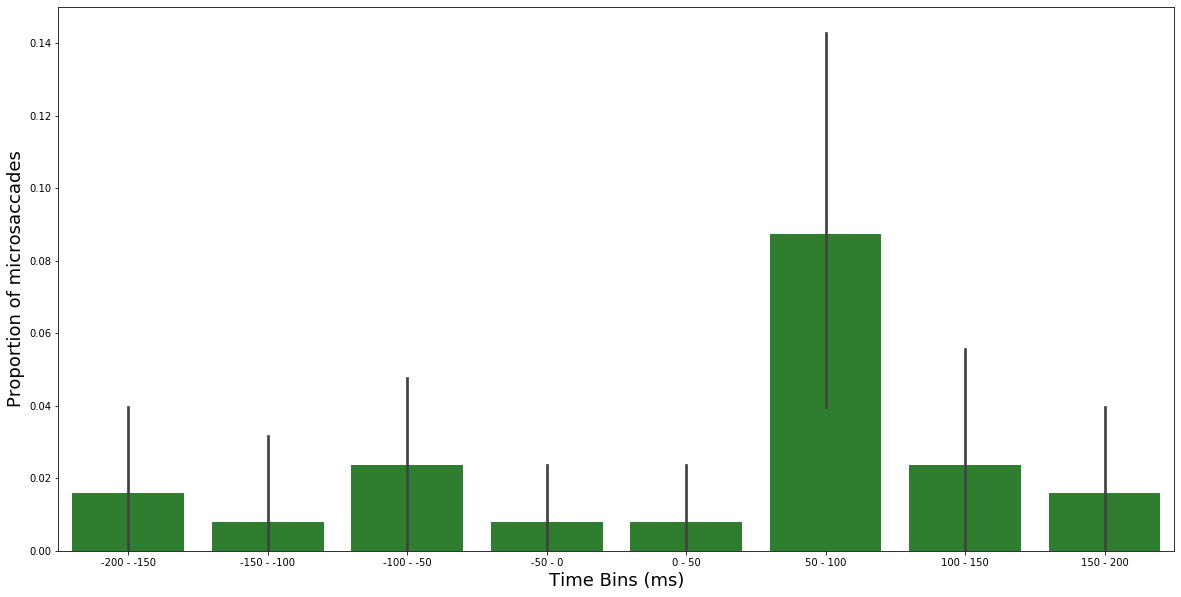

In [117]:
filteredMicrosaccadeData=MicrosaccadeData.groupby(['SubjectID','timebin']).mean()['NumMicrosaccades'].reset_index()
plt.figure(figsize=(20,10))
#outliers are hidden for the time being as it makes it harder to visualize the data
sns.barplot(x="timebin",y="NumMicrosaccades",data=MicrosaccadeData,color="forestgreen")
plt.xlabel('Time Bins (ms)', size=18)
plt.ylabel('Proportion of microsaccades', size=18)
# plt.savefig('ProportionMicrosaccadeVtimebins.pdf')

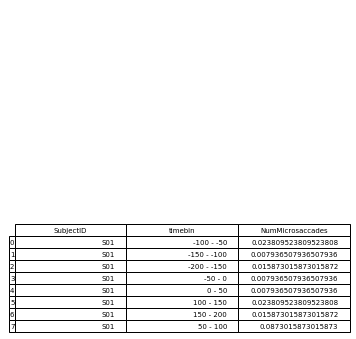

In [126]:
from pandas.plotting import table 
ax=plt.subplot(111,frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
filteredMicrosaccadeData=MicrosaccadeData.groupby(['SubjectID','timebin']).mean()['NumMicrosaccades'].reset_index()
table(ax,filteredMicrosaccadeData)
# plt.savefig('MicrosaccadeSummaryTable.pdf',bbox_inches='tight')